In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

def merge_duplicate_columns(df):
    """
    Merges columns that are duplicates following the pattern:
    - Base column (e.g., "Oasis")
    - Kill variant (e.g., "Kill Oasis") 
    - Kills variant (e.g., "Kills Oasis")
    
    Priority: Base > Kills > Kill (first non-null value wins)
    """
    df = df.copy()
    column_groups = defaultdict(list)
    
    for col in df.columns:
        if col.startswith("Kill "):
            base_name = col[5:]
            column_groups[base_name].append(("kill", col))
        elif col.startswith("Kills "):
            base_name = col[6:]
            column_groups[base_name].append(("kills", col))
        else:
            column_groups[col].append(("base", col))
    
    columns_to_drop = []
    
    for base_name, variants in column_groups.items():
        if len(variants) > 1:
            base_col = None
            kills_col = None
            kill_col = None
            
            for variant_type, col_name in variants:
                if variant_type == "base":
                    base_col = col_name
                elif variant_type == "kills":
                    kills_col = col_name
                elif variant_type == "kill":
                    kill_col = col_name
            
            target_col = base_col or kills_col or kill_col
            
            for variant_type, col_name in variants:
                if col_name != target_col:
                    df[col_name] = df[col_name].replace(0, np.nan)
            
            if base_col and base_col != target_col:
                df[base_col] = df[base_col].replace(0, np.nan)
            
            merge_order = []
            if base_col: merge_order.append(base_col)
            if kills_col: merge_order.append(kills_col)  
            if kill_col: merge_order.append(kill_col)
            
            if len(merge_order) > 1:
                for i in range(1, len(merge_order)):
                    df[merge_order[0]] = df[merge_order[0]].fillna(df[merge_order[i]])
                    columns_to_drop.append(merge_order[i])
    
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    return df

In [2]:
# figuring out the best player over all minigames 

'''
    Each Minigame may yield a total of 100 points per player. 
    Records #1 through #10 are considered 

    If a minigame has multiple maps, the 100 points are distributed equally. For Sammelwahn and Replika, the sum over all records is considered solely. 

    E.g. Frozen Path (1 Map Minigame)
    #1 player: 100 points
    #2 player: 90 points
    #3 player: 80 points
    ...
    #10 player: 10 points

    E.g. Schießstand (3 Map Minigame)
    Map 1: 
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 2:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 3:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...

    E.g. Speed Race (5 Map Minigame)
    Map 1:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...
    Map 2:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...

    Thus, a player holding #1 records in a minigame will always be assigned 100 points. 
'''

'\n    Each Minigame may yield a total of 100 points per player. \n    Records #1 through #10 are considered \n\n    If a minigame has multiple maps, the 100 points are distributed equally. For Sammelwahn and Replika, the sum over all records is considered solely. \n\n    E.g. Frozen Path (1 Map Minigame)\n    #1 player: 100 points\n    #2 player: 90 points\n    #3 player: 80 points\n    ...\n    #10 player: 10 points\n\n    E.g. Schießstand (3 Map Minigame)\n    Map 1: \n    #1 player: 100/3 (33.333) points\n    #2 player: 90/3 (30) points\n    ...\n    Map 2:\n    #1 player: 100/3 (33.333) points\n    #2 player: 90/3 (30) points\n    ...\n    Map 3:\n    #1 player: 100/3 (33.333) points\n    #2 player: 90/3 (30) points\n    ...\n\n    E.g. Speed Race (5 Map Minigame)\n    Map 1:\n    #1 player: 100/5 (20) points\n    #2 player: 90/5 (18) points\n    ...\n    Map 2:\n    #1 player: 100/5 (20) points\n    #2 player: 90/5 (18) points\n    ...\n\n    Thus, a player holding #1 records in 

In [3]:
def remove_duplicate_columns(df):
    """
    Removes duplicate columns from DataFrame.
    Keeps the first occurrence of each duplicate column.
    """
    df = df.loc[:, ~df.columns.duplicated()]
    return df

In [4]:
import os
import re 
import pandas as pd
import seaborn as sns 
import numpy as np 

pointMiniGames = "Sammelwahn, Schießstand, Mauerfall, Survivalgames, Skywars, Lasertag, Minengefecht, Einer im Köcher, Paintball, Spleef, Buntes Chaos, Reihenfolge, Duelle, Turmroulette" 
timeMiniGames = "Wettrennen, Parkour, Pferderennen, Drachenflucht, Replika, Blockhüpfer, Todeswürfel, Freier Fall, Elytrarennen, Waffenfolge, Minenfeld, Kletterkönig, Ampelrennen, Hoch hinaus, Frostiger Pfad, Runterpurzeln, Blockhüpfer"

def getPlayerPaths():
    file_list = os.listdir('in-new')
    print(file_list)
    return file_list

def read_file(file):
    try:
        with open('in-new/' + file, 'r', encoding='utf-8') as f:
            data = f.read()
    except UnicodeDecodeError:
        # print(f'Error: {file} contains invalid characters for UTF-8. Trying with latin-1.')
        try:
            with open('in-new/' + file, 'r', encoding='latin-1') as f:
                data = f.read()
        except Exception as e:
            print(f'Error: Could not read {file} with latin-1 encoding. {e}')
            return None
    except FileNotFoundError:
        print(f'Error: {file} not found.')
        return None
    except Exception as e:
        print(f'Error: An unexpected error occurred while reading {file}. {e}')
        return None

    if "TooltipEvent" not in data:
        print(f'Error: {file} does not contain any TooltipEvent data')
        return None
    else:
        data = data.replace('TooltipEvent, ', '')
    
    return data


def getRecordData(playerPath, minigame):
    # if read_file(playerPath) is None: return None

    try: 
        data = read_file(playerPath).split('\n')
        for line in data: 
            if minigame in line: 
                minigameData = line
                minigameData = minigameData.replace(minigame, '').strip()
                return minigameData  # return the data instead of printing it
    except: return None


def create_dataframe(input_string, minigame):

    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(?:(\d+)\s*min\s*)?(?:(\d+)\s*s\s*)?(\d+)\s*ms'

    # Find all matches in the input string
    try: matches = re.findall(pattern, input_string)
    except: matches = None

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    if matches: 
        for match in matches:
            map_name = match[0]
            minutes = int(match[1] or 0)
            seconds = int(match[2] or 0) + int(match[3]) / 1000
            time_seconds = minutes * 60 + seconds
            data[map_name] = time_seconds
    else: return pd.DataFrame()

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])


    return df

def createPointDataframe(input_string, minigame):
    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(\d+)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    for match in matches:
        map_name = match[0]
        time_value = int(match[1])
        data[map_name] = time_value

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])
    return df.fillna(0)

def getRecordsDataframe(minigame='Wettrennen', save=False, log=False, html=False, rank=True):

    paths = getPlayerPaths()

    outDf = pd.DataFrame()

    if log:
        print(f'processing {minigame}...')

    if minigame in pointMiniGames: 
        pass
    elif minigame in timeMiniGames:
        pass
    else: 
        ValueError('Not a valid minigame name')

    for i in paths:
        if minigame in timeMiniGames:
            df = create_dataframe(getRecordData(playerPath=i, minigame=minigame), minigame)

        if minigame in pointMiniGames:
            try: 
                df = createPointDataframe(getRecordData(playerPath=i, minigame=minigame), minigame)
                df.fillna(0, inplace=True)
            except: 
                continue

        if df is not None:  
            df.index = [i.replace('.txt', '')]
            outDf = pd.concat([outDf, df])

    outPath = 'out/' + minigame + '.json'

    '''
        Minigame Specific changes to the df
    '''

    if ("Replika" in minigame): 

        replikaDf = outDf 

        # fillNa columns without "ms" with values from "ms", e.g. ms Arrow -> Arrow, then drop "ms" columns

        try:
            replikaDf["Arrow"] = replikaDf["Arrow"].fillna(replikaDf["ms Arrow"])
            replikaDf["Cow"] = replikaDf["Cow"].fillna(replikaDf["ms Cow"])
            replikaDf["Deadpool"] = replikaDf["Deadpool"].fillna(replikaDf["ms Deadpool"])
            replikaDf["Doge"] = replikaDf["Doge"].fillna(replikaDf["ms Doge"])
            replikaDf["Sonic"] = replikaDf["Sonic"].fillna(replikaDf["ms Sonic"])

            replikaDf.drop(columns=["ms Arrow", "ms Cow", "ms Deadpool", "ms Doge", "ms Sonic"], inplace=True)
        except: print("Warning, >ms< columns not found in ReplikaDf")

        replikaDf.fillna(25, inplace=True) # assigning a value to a never-played-before pattern, 17 perturbs worse player order and alt account stats lol, 27 is probably too much, difficult to choose an appropriate value here
        row_sums = replikaDf.sum(axis=1)
        
        # Append the sum as a new column
        replikaDf['Sum'] = row_sums

        # Re-indexing
        replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)
    
        # Move 'Sum' column to the first position
        cols = replikaDf.columns.tolist()
        cols = ['Sum'] + [col for col in cols if col != 'Sum']
        replikaDf = replikaDf[cols]

        # replace 25 values again with None
        replikaDf = replikaDf.replace(25, np.nan)

        # replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)


        # Removing player data with too many NaNs (players that haven't played most of the patterns)
        # replikaDf = replikaDf.drop(columns=["Ritokii", "Feinberg", "Sebi1801"])

        outDf = replikaDf

    if ("Sammelwahn" in minigame):

            row_sums = outDf.sum(axis=1)

            # Append the sum as a new column
            outDf['Sum'] = row_sums

            # Re-indexing
            outDf = outDf.reindex(sorted(outDf.columns), axis=1)

            # Move 'Sum' column to the first position
            cols = outDf.columns.tolist()
            cols = ['Sum'] + [col.lstrip() for col in cols if col != 'Sum']
            outDf = outDf[cols]

            # remove "Punkte" from all columns
            outDf.columns = outDf.columns.str.replace('Punkte', '')

    if ("Lasertag" in minigame):
        outDf = merge_duplicate_columns(outDf)

    if ("Einer im Köcher" in minigame):
        outDf = merge_duplicate_columns(outDf)
        
    if ("Paintball" in minigame):
        outDf = merge_duplicate_columns(outDf)

    if ("Skywars" in minigame):
        outDf = merge_duplicate_columns(outDf)

    if ("Survivalgames" in minigame and True):
        outDf = merge_duplicate_columns(outDf)

    if ("Minengefecht" in minigame):
        outDf = merge_duplicate_columns(outDf)

    if ("Mauerfall" in minigame):
        outDf = merge_duplicate_columns(outDf)

    if ("Schie" in minigame):
        outDf["Punkte City"] = outDf["Punkte City"].replace(0, np.nan)
        outDf["City"] = outDf["City"].replace(0, np.nan)

        outDf["temp1"] = outDf["City"].fillna(outDf["Punkte City"])
        try: outDf.drop(columns=["City", "Punkte City"], inplace=True)
        except: pass

        outDf["City"] = outDf["temp1"]

        outDf["Punkte Jungle"] = outDf["Punkte Jungle"].replace(0, np.nan)

        outDf["temp1"] = outDf["Punkte Jungle"]
        try: outDf.drop(columns=["Punkte Jungle"], inplace=True)
        except: pass

        outDf["Jungle"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
    if ("Frostiger" in minigame): 
        # remove values bigger than 100 with nan
        outDf = outDf.where(outDf < 100, np.nan)

    if ("Duel" in minigame): 
        outDf = outDf.where(outDf > 10, 0.0)

    if ("Einer im Köcher" in minigame):

        try:
            outDf["Tötung Asia"] = outDf["Tötung Asia"].replace(0, np.nan)
            outDf["Asia"] = outDf["Asia"].replace(0, np.nan)

            outDf["temp1"] = outDf["Asia"].fillna(outDf["Tötung Asia"])
            outDf.drop(columns=["Asia", "Tötung Asia"], inplace=True)
            
            outDf["Asia"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)
        except: pass

    if ("Buntes" in minigame):
        outDf = outDf.fillna(0)
        
        outDf['temp1'] = outDf["Runden Cyberpunk"].fillna(outDf["Cyberpunk"])
        outDf.drop(columns=["Runden Cyberpunk", "Cyberpunk"], inplace=True)

        outDf['Cyberpunk'] = outDf['temp1']

        outDf.drop(columns=["temp1"], inplace=True)

    if ("Pferd" in minigame):
        outDf["s Arena"] = outDf["s Arena"].replace(0, np.nan)
        outDf["Wario's Arena"] = outDf["s Arena"]

        outDf.drop(columns=["s Arena"], inplace=True)


    # Sorting columns alphabetically for any outDf except if minigame == "Replika" (sum column)
    
    if ("Replika" not in minigame):
        if ("Sammelwahn" not in minigame):
            outDf = outDf.reindex(sorted(outDf.columns), axis=1)




    '''
        debugging options
    '''
        
    if save: 
        if "Replika" in minigame: 
            json_df = outDf.iloc[:, 1:]
            json_df.T.to_json(outPath)
        
        else: outDf.T.to_json(outPath) 

    if log: 
        print(f'{minigame} processed')
    
    if rank: 
        if minigame in pointMiniGames: 
            outDf = outDf.rank(ascending=False, method='min', axis=0)
        if minigame in timeMiniGames:
            if "Drache" in minigame: 
                outDf = outDf.rank(ascending=False, method='min', axis=0)
            else:
                outDf = outDf.rank(ascending=True, method='min', axis=0)

    if html == False: 
        return outDf

In [5]:
df = getRecordsDataframe(minigame='Schießstand', save=False, log=True, html=False, rank=True)

df.loc['Fflopse']

# df.columns

['__egE.txt', 'Tammywood.txt', 'BunnyKiko.txt', 'SpeckyCut.txt', 'sirmigorius.txt', 'Hyxeed.txt', 'Karsten5.txt', 'demiu.txt', 'SpinCrafter.txt', 'NanamiElvi.txt', '_n3d.txt', 'Sebi1801.txt', 'AnzeigeGehtRaus.txt', 'krstn_.txt', 'JayMinInSane.txt', 'Persidieus.txt', 'N3XV.txt', 'Wissender.txt', 'Gryzes.txt', 'jimmi4Life.txt', 'Gobo9.txt', 'Anni808.txt', 'LeWi_100.txt', '_Waldi_.txt', 'Grapfen.txt', 'PixlNight.txt', 'dossantosaveiro_.txt', 'agowskyy.txt', 'TheBreadHD.txt', 'Axollotel.txt', 'T_Niko_T.txt', 'Vanillinchen.txt', 'Odlaa.txt', 'D4rkCookie.txt', '.DS_Store', 'yzvm.txt', 'Tim_Voltia.txt', 'xBaumeisterin.txt', 'vzqs.txt', 'Ungluecklicher.txt', 'Lutorix.txt', 'Ninivee.txt', 'ArthurAlchemist.txt', 'redbrll.txt', 'Gfrasti.txt', 'Muniix.txt', 'Tomiokey.txt', 'Carl1_1.txt', 'DerAutist.txt', 'PolizeiDreamy.txt', 'xX_Dima_ggg_Xx6.txt', 'CuzImKnxck.txt', 'Falke23_5.txt', 'TheFabo.txt', 'DieserBear.txt', 'SWLegende.txt', 'Picutar.txt', '2B9.txt', 'Otronix.txt', 'Schmaarek.txt', 'musi1999

City               2.0
Farm               3.0
Jungle             4.0
Punkte Chambers    NaN
Name: Fflopse, dtype: float64

In [6]:
def getBestPlayer(minigame='Wettrennen'):
    df = getRecordsDataframe(minigame=minigame, save=False, log=True, html=False, rank=True)

    num_cols = len(df.columns) 

    '''
    Each Minigame may yield a total of 100 points per player. 
    Records #1 through #10 are considered 

    If a minigame has multiple maps, the 100 points are distributed equally. For Sammelwahn and Replika, the sum over all records is considered solely. 

    E.g. Frozen Path (1 Map Minigame)
    #1 player: 100 points
    #2 player: 90 points
    #3 player: 80 points
    ...
    #10 player: 10 points

    E.g. Schießstand (3 Map Minigame)
    Map 1: 
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 2:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 3:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...

    E.g. Speed Race (5 Map Minigame)
    Map 1:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...
    Map 2:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...

    Thus, a player holding #1 records in a minigame will always be assigned 100 points. 
    '''

    # fill values > 10.0 with 0
    df = df.where(df < 10.0, 0)

    # replace the rank values in the dataframe with the apprpriate score values

    if minigame in pointMiniGames:
        df = df.replace({1.0: 100, 2.0: 90, 3.0: 80, 4.0: 70, 5.0: 60, 6.0: 50, 7.0: 40, 8.0: 30, 9.0: 20, 10.0: 10})
    if minigame in timeMiniGames:
        df = df.replace({1.0: 100, 2.0: 90, 3.0: 80, 4.0: 70, 5.0: 60, 6.0: 50, 7.0: 40, 8.0: 30, 9.0: 20, 10.0: 10})

    # sum the scores for each player
    df['PointSum'] = df.sum(axis=1) / num_cols

    # sort the dataframe by the PointSum column
    df = df.sort_values(by='PointSum', ascending=False)

    # for Sammelwahn and Replika, simply get the points from the sum column
    if minigame in "Sammelwahn Replika":
        df['Pointsum'] = df['Sum']

    return df
    

In [7]:
# getBestPlayer(minigame='Wettrennen')

In [8]:
for minigame in (pointMiniGames + ", " + timeMiniGames).split(', '): 
    temp = getBestPlayer(minigame=minigame)

    # rename PointSum to minigame name
    temp.rename(columns={'PointSum': minigame}, inplace=True)

    # drop all columns but the pointDf column
    temp = temp[[minigame]]

    # concat all minigame dataframes
    try: 
        outDf = pd.concat([outDf, temp], axis=1)
    except: 
        outDf = temp


['__egE.txt', 'Tammywood.txt', 'BunnyKiko.txt', 'SpeckyCut.txt', 'sirmigorius.txt', 'Hyxeed.txt', 'Karsten5.txt', 'demiu.txt', 'SpinCrafter.txt', 'NanamiElvi.txt', '_n3d.txt', 'Sebi1801.txt', 'AnzeigeGehtRaus.txt', 'krstn_.txt', 'JayMinInSane.txt', 'Persidieus.txt', 'N3XV.txt', 'Wissender.txt', 'Gryzes.txt', 'jimmi4Life.txt', 'Gobo9.txt', 'Anni808.txt', 'LeWi_100.txt', '_Waldi_.txt', 'Grapfen.txt', 'PixlNight.txt', 'dossantosaveiro_.txt', 'agowskyy.txt', 'TheBreadHD.txt', 'Axollotel.txt', 'T_Niko_T.txt', 'Vanillinchen.txt', 'Odlaa.txt', 'D4rkCookie.txt', '.DS_Store', 'yzvm.txt', 'Tim_Voltia.txt', 'xBaumeisterin.txt', 'vzqs.txt', 'Ungluecklicher.txt', 'Lutorix.txt', 'Ninivee.txt', 'ArthurAlchemist.txt', 'redbrll.txt', 'Gfrasti.txt', 'Muniix.txt', 'Tomiokey.txt', 'Carl1_1.txt', 'DerAutist.txt', 'PolizeiDreamy.txt', 'xX_Dima_ggg_Xx6.txt', 'CuzImKnxck.txt', 'Falke23_5.txt', 'TheFabo.txt', 'DieserBear.txt', 'SWLegende.txt', 'Picutar.txt', '2B9.txt', 'Otronix.txt', 'Schmaarek.txt', 'musi1999

In [9]:
outDf['Schießstand']

Gobo9           17.5
Allooy          10.0
Umgfoin          0.0
Fflopse         60.0
Luxemburq        0.0
                ... 
demiu            NaN
JayMinInSane     NaN
Tammywood        NaN
KINT0            NaN
SmartyxD         NaN
Name: Schießstand, Length: 253, dtype: float64

In [10]:
getBestPlayer(minigame='Schießstand')

['__egE.txt', 'Tammywood.txt', 'BunnyKiko.txt', 'SpeckyCut.txt', 'sirmigorius.txt', 'Hyxeed.txt', 'Karsten5.txt', 'demiu.txt', 'SpinCrafter.txt', 'NanamiElvi.txt', '_n3d.txt', 'Sebi1801.txt', 'AnzeigeGehtRaus.txt', 'krstn_.txt', 'JayMinInSane.txt', 'Persidieus.txt', 'N3XV.txt', 'Wissender.txt', 'Gryzes.txt', 'jimmi4Life.txt', 'Gobo9.txt', 'Anni808.txt', 'LeWi_100.txt', '_Waldi_.txt', 'Grapfen.txt', 'PixlNight.txt', 'dossantosaveiro_.txt', 'agowskyy.txt', 'TheBreadHD.txt', 'Axollotel.txt', 'T_Niko_T.txt', 'Vanillinchen.txt', 'Odlaa.txt', 'D4rkCookie.txt', '.DS_Store', 'yzvm.txt', 'Tim_Voltia.txt', 'xBaumeisterin.txt', 'vzqs.txt', 'Ungluecklicher.txt', 'Lutorix.txt', 'Ninivee.txt', 'ArthurAlchemist.txt', 'redbrll.txt', 'Gfrasti.txt', 'Muniix.txt', 'Tomiokey.txt', 'Carl1_1.txt', 'DerAutist.txt', 'PolizeiDreamy.txt', 'xX_Dima_ggg_Xx6.txt', 'CuzImKnxck.txt', 'Falke23_5.txt', 'TheFabo.txt', 'DieserBear.txt', 'SWLegende.txt', 'Picutar.txt', '2B9.txt', 'Otronix.txt', 'Schmaarek.txt', 'musi1999

Error: Lord_Weibull.txt does not contain any TooltipEvent data
Error: Scuprum.txt does not contain any TooltipEvent data
Error: Dubbly.txt does not contain any TooltipEvent data
Error: destr0yed_.txt does not contain any TooltipEvent data
Schießstand processed


,City,Farm,Jungle,Punkte Chambers,PointSum
Fflopse,90.0,80.0,70.0,0.0,60.0
cediiiiii_10,20.0,30.0,90.0,100.0,60.0
Ex4cted,100.0,60.0,30.0,40.0,57.5
JOW23,30.0,80.0,80.0,0.0,47.5
rotmann2,0.0,90.0,0.0,50.0,35.0
...,...,...,...,...,...
byTobi,0.0,0.0,0.0,0.0,0.0
Shiewk,0.0,0.0,0.0,0.0,0.0
La_meleagro,0.0,0.0,0.0,0.0,0.0
Luxemburq,0.0,0.0,0.0,0.0,0.0


In [11]:
remove_duplicate_columns(outDf).columns

Index(['Sammelwahn', 'Schießstand', 'Mauerfall', 'Survivalgames', 'Skywars',
       'Lasertag', 'Minengefecht', 'Einer im Köcher', 'Paintball', 'Spleef',
       'Buntes Chaos', 'Reihenfolge', 'Duelle', 'Turmroulette', 'Wettrennen',
       'Parkour', 'Pferderennen', 'Drachenflucht', 'Replika', 'Blockhüpfer',
       'Todeswürfel', 'Freier Fall', 'Elytrarennen', 'Waffenfolge',
       'Minenfeld', 'Kletterkönig', 'Ampelrennen', 'Hoch hinaus',
       'Frostiger Pfad', 'Runterpurzeln'],
      dtype='object')

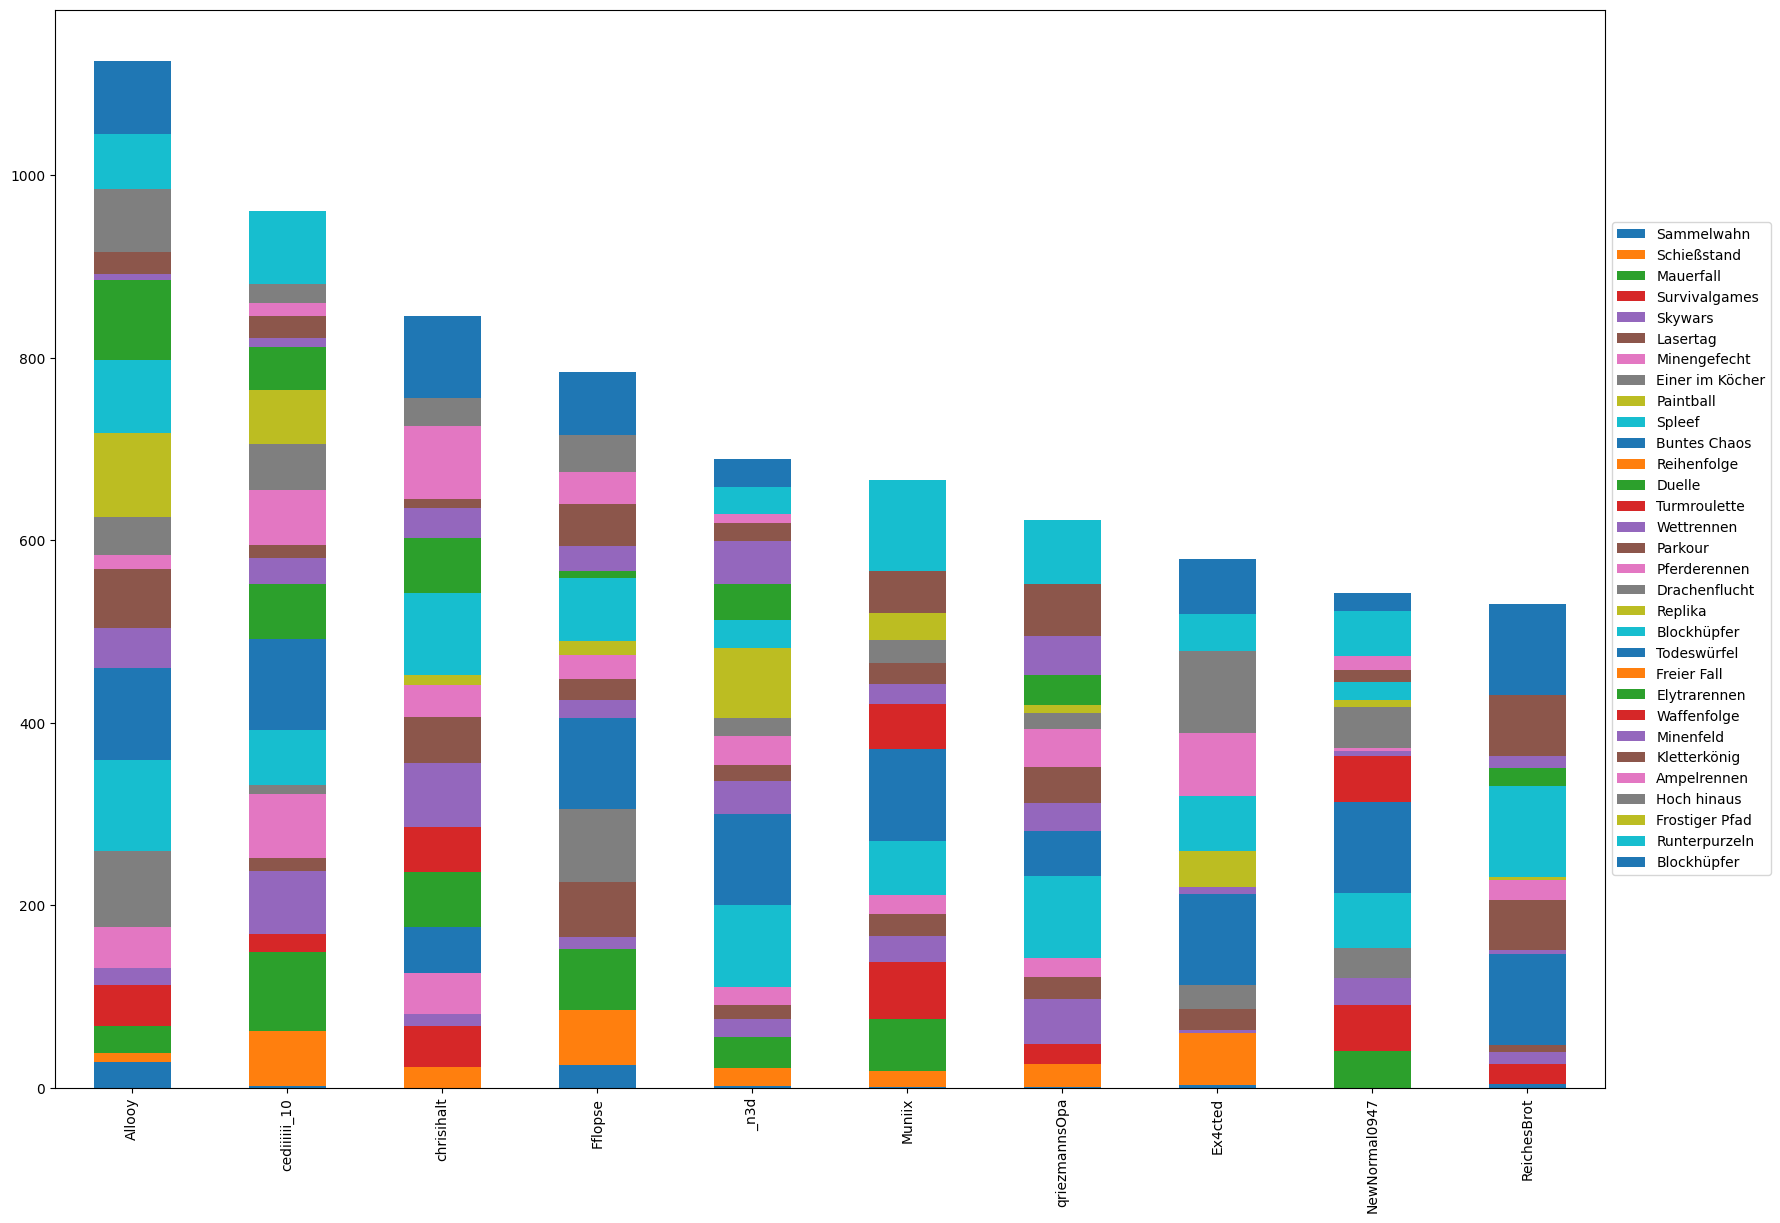

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px

# print(outDf)

# sum all lines to get the total score

outDf['Total'] = outDf.sum(axis=1)

outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# crop df to the top 10 players and plot the data, as a stacked barplot, place legend outside

cropDf = outDf.head(10)

cropDf = cropDf.drop(columns=['Total'])

cropDf.plot(kind='bar', stacked=True, figsize=(20, 14))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [13]:
outDf

,Sammelwahn,Schießstand,Mauerfall,Survivalgames,Skywars,Lasertag,Minengefecht,Einer im Köcher,Paintball,Spleef,...,Elytrarennen,Waffenfolge,Minenfeld,Kletterkönig,Ampelrennen,Hoch hinaus,Frostiger Pfad,Runterpurzeln,Blockhüpfer,Total
Allooy,27.857143,10.0,30.000000,45.0,18.333333,0.0,45.0,83.333333,0.0,100.0,...,87.5,0.0,6.666667,23.333333,0.0,70.0,0.0,60.0,80.0,1125.642454
cediiiiii_10,2.142857,60.0,86.666667,20.0,68.333333,15.0,70.0,10.000000,0.0,60.0,...,47.5,0.0,10.000000,23.333333,15.0,20.0,0.0,80.0,0.0,960.552462
chrisihalt,0.000000,22.5,0.000000,45.0,13.333333,0.0,45.0,0.000000,0.0,0.0,...,60.0,0.0,33.333333,10.000000,80.0,30.0,0.0,0.0,90.0,845.692090
Fflopse,25.000000,60.0,66.666667,0.0,13.333333,60.0,0.0,80.000000,0.0,0.0,...,7.5,0.0,26.666667,46.666667,35.0,40.0,0.0,0.0,70.0,784.915254
_n3d,1.666667,20.0,33.333333,0.0,20.000000,15.0,20.0,0.000000,0.0,90.0,...,40.0,0.0,46.666667,20.000000,10.0,0.0,0.0,30.0,30.0,688.867232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PolizeiDreamy,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
Falke_01,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
Flitzi_Dino,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
Anni808,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [14]:
import plotly.graph_objects as go

# Sum all columns to get the total score
outDf['Total'] = outDf.sum(axis=1)

# Sort by total score and fill N/A values with 0
outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# Crop to top 10 players
cropDf = outDf.head(20).copy()

# Drop the 'Total' column for plotting
cropDf = cropDf.drop(columns=['Total'])

# Create a color palette
color_palette = px.colors.qualitative.Safe

# Create the stacked bar plot
fig = go.Figure()

cropDf = remove_duplicate_columns(cropDf)

for column in cropDf.columns.difference(['Player']):
    fig.add_trace(go.Bar(
        x=cropDf.index,
        y=cropDf[column],
        name=column,
        marker_color=color_palette[len(fig.data) % len(color_palette)]
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Overall Record Comparison - Top 20 Players',
    xaxis=dict(title='Player'),
    yaxis=dict(title='Points'),
    #height=800,
    #width=1000,
    legend=dict(
        x=1.05,
        y=0.5,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(0, 0, 0, 0)'
    ),
    margin=dict(r=200),  # Adjust right margin to make room for the legend
    annotations=[
        dict(
            x=0.5,
            y=-0.235,
            xref='paper',
            yref='paper',
            text='Max 100 points per minigame. Records #1 through #10 are considered (#1: 100, #2: 90, ..., #10: 10). If a minigame has multiple maps, the 100 points are distributed equally. fflopse.github.io/MCP-Records/data-analysis/global-ranking.ipynb',
            showarrow=False,
            font=dict(size=12),
            xanchor='center'
        )
    ]
)

fig.show()

# save the plot as an html file

fig.write_html('out/overall_record_comparison.html')

In [15]:
import plotly.graph_objects as go

# Sum all columns to get the total score
outDf['Total'] = outDf.sum(axis=1)

# Sort by total score and fill N/A values with 0
outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# Crop to top 10 players
cropDf = outDf.head(40).copy()

# Drop the 'Total' column for plotting
cropDf = cropDf.drop(columns=['Total'])

# Create a color palette
color_palette = px.colors.qualitative.Safe

# Create the stacked bar plot
fig = go.Figure()

cropDf = remove_duplicate_columns(cropDf)

for column in cropDf.columns.difference(['Player']):
    fig.add_trace(go.Bar(
        x=cropDf.index,
        y=cropDf[column],
        name=column,
        marker_color=color_palette[len(fig.data) % len(color_palette)]
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Extended Overall Record Comparison - Top 40 Players',
    xaxis=dict(title='Player'),
    yaxis=dict(title='Points'),
    #height=800,
    #width=1000,
    legend=dict(
        x=1.05,
        y=0.5,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(0, 0, 0, 0)'
    ),
    margin=dict(r=200),  # Adjust right margin to make room for the legend
    annotations=[
        dict(
            x=0.5,
            y=1.1635,
            xref='paper',
            yref='paper',
            text='Max 100 points per minigame. Records #1 through #10 of games & maps in the active pool are considered (#1: 100, #2: 90, ..., #10: 10). If a minigame has multiple maps, the 100 points are distributed equally. fflopse.github.io/MCP-Records/data-analysis/global-ranking.ipynb',
            showarrow=False,
            font=dict(size=12),
            xanchor='center'
        )
    ]
)

fig.show()

# save the plot as an html file

fig.write_html('out/ext_overall_record_comparison.html')

In [16]:
import plotly.graph_objects as go
import plotly.express as px

# Sum all columns to get the total score
outDf['Total'] = outDf.sum(axis=1)

outDf = remove_duplicate_columns(outDf)

# Sort by total score and fill N/A values with 0
outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# Crop to top 100 players
cropDf = outDf.head(100).copy()

# Compute Total again for the cropped data
cropDf['Total'] = cropDf.drop(columns=['Total']).sum(axis=1)

# Sort the cropped data by Total
cropDf = cropDf.sort_values(by='Total', ascending=False)

# Drop the 'Total' column for plotting
cropDf = cropDf.drop(columns=['Total'])

# Create integer positions and player names
positions = list(range(len(cropDf)))
player_names = list(cropDf.index)

# Create a color palette
color_palette = px.colors.qualitative.Safe

# Create the stacked bar plot
fig = go.Figure()

cropDf = remove_duplicate_columns(cropDf)

for column in cropDf.columns:
   fig.add_trace(go.Bar(
       x=positions,
       y=cropDf[column],
       name=column,
       marker_color=color_palette[len(fig.data) % len(color_palette)]
   ))

# Update layout
fig.update_layout(
   barmode='stack',
   title='Extended Overall Record Comparison - Top 100 Players',
   xaxis=dict(
       title='Player',
       tickmode='array',
       tickvals=positions,
       ticktext=player_names
   ),
   yaxis=dict(title='Points'),
   legend=dict(
       x=1.05,
       y=0.5,
       traceorder='normal',
       font=dict(size=12),
       bgcolor='rgba(255, 255, 255, 0)',
       bordercolor='rgba(0, 0, 0, 0)'
   ),
   margin=dict(r=200),
   annotations=[
       dict(
           x=0.5,
           y=1.1635,
           xref='paper',
           yref='paper',
           text='Max 100 points per minigame. Records #1 through #10 of games & maps in the active pool are considered (#1: 100, #2: 90, ..., #10: 10). If a minigame has multiple maps, the 100 points are distributed equally. fflopse.github.io/MCP-Records/data-analysis/global-ranking.ipynb',
           showarrow=False,
           font=dict(size=12),
           xanchor='center'
       )
   ]
)

fig.show()

fig.write_html('out/full_overall_record_comparison.html')

In [17]:
cropDf

,Sammelwahn,Schießstand,Mauerfall,Survivalgames,Skywars,Lasertag,Minengefecht,Einer im Köcher,Paintball,Spleef,...,Todeswürfel,Freier Fall,Elytrarennen,Waffenfolge,Minenfeld,Kletterkönig,Ampelrennen,Hoch hinaus,Frostiger Pfad,Runterpurzeln
Allooy,27.857143,10.0,30.000000,45.0,18.333333,0.0,45.0,83.333333,0.0,100.0,...,0.0,0.0,87.5,0.0,6.666667,23.333333,0.0,70.0,0.0,60.0
cediiiiii_10,2.142857,60.0,86.666667,20.0,68.333333,15.0,70.0,10.000000,0.0,60.0,...,0.0,0.0,47.5,0.0,10.000000,23.333333,15.0,20.0,0.0,80.0
chrisihalt,0.000000,22.5,0.000000,45.0,13.333333,0.0,45.0,0.000000,0.0,0.0,...,0.0,0.0,60.0,0.0,33.333333,10.000000,80.0,30.0,0.0,0.0
Fflopse,25.000000,60.0,66.666667,0.0,13.333333,60.0,0.0,80.000000,0.0,0.0,...,0.0,0.0,7.5,0.0,26.666667,46.666667,35.0,40.0,0.0,0.0
Muniix,0.714286,17.5,56.666667,62.5,28.333333,25.0,20.0,0.000000,0.0,60.0,...,0.0,0.0,0.0,0.0,0.000000,46.666667,0.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GamemasterNiki,0.000000,0.0,0.000000,0.0,16.666667,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
LucaaOn,0.714286,0.0,0.000000,0.0,23.333333,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
yachayubin,0.000000,0.0,0.000000,0.0,3.333333,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
SatzdesPytag0ras,0.000000,0.0,0.000000,22.5,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [18]:
outDf

,Sammelwahn,Schießstand,Mauerfall,Survivalgames,Skywars,Lasertag,Minengefecht,Einer im Köcher,Paintball,Spleef,...,Freier Fall,Elytrarennen,Waffenfolge,Minenfeld,Kletterkönig,Ampelrennen,Hoch hinaus,Frostiger Pfad,Runterpurzeln,Total
Allooy,27.857143,10.0,30.000000,45.0,18.333333,0.0,45.0,83.333333,0.0,100.0,...,0.0,87.5,0.0,6.666667,23.333333,0.0,70.0,0.0,60.0,4502.569814
cediiiiii_10,2.142857,60.0,86.666667,20.0,68.333333,15.0,70.0,10.000000,0.0,60.0,...,0.0,47.5,0.0,10.000000,23.333333,15.0,20.0,0.0,80.0,3842.209847
chrisihalt,0.000000,22.5,0.000000,45.0,13.333333,0.0,45.0,0.000000,0.0,0.0,...,0.0,60.0,0.0,33.333333,10.000000,80.0,30.0,0.0,0.0,3382.768362
Fflopse,25.000000,60.0,66.666667,0.0,13.333333,60.0,0.0,80.000000,0.0,0.0,...,0.0,7.5,0.0,26.666667,46.666667,35.0,40.0,0.0,0.0,3139.661017
_n3d,1.666667,20.0,33.333333,0.0,20.000000,15.0,20.0,0.000000,0.0,90.0,...,0.0,40.0,0.0,46.666667,20.000000,10.0,0.0,0.0,30.0,2755.468927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
StaudammAusHolz,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
GlowyDusk,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
.DS_Store,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
Keenaai,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [19]:
print(outDf['Total'].head(10))  # Should show descending values

Allooy           4502.569814
cediiiiii_10     3842.209847
chrisihalt       3382.768362
Fflopse          3139.661017
_n3d             2755.468927
Muniix           2666.167877
qriezmannsOpa    2488.789346
Ex4cted          2316.439064
NewNormal0947    2170.779661
ReichesBrot      2121.197740
Name: Total, dtype: float64


In [20]:
print(cropDf.index[:10])  # Should show the top 10 player names

Index(['Allooy', 'cediiiiii_10', 'chrisihalt', 'Fflopse', 'Muniix', '_n3d',
       'qriezmannsOpa', 'NewNormal0947', 'Ex4cted', 'Gobo9'],
      dtype='object')


In [21]:
outDf

,Sammelwahn,Schießstand,Mauerfall,Survivalgames,Skywars,Lasertag,Minengefecht,Einer im Köcher,Paintball,Spleef,...,Freier Fall,Elytrarennen,Waffenfolge,Minenfeld,Kletterkönig,Ampelrennen,Hoch hinaus,Frostiger Pfad,Runterpurzeln,Total
Allooy,27.857143,10.0,30.000000,45.0,18.333333,0.0,45.0,83.333333,0.0,100.0,...,0.0,87.5,0.0,6.666667,23.333333,0.0,70.0,0.0,60.0,4502.569814
cediiiiii_10,2.142857,60.0,86.666667,20.0,68.333333,15.0,70.0,10.000000,0.0,60.0,...,0.0,47.5,0.0,10.000000,23.333333,15.0,20.0,0.0,80.0,3842.209847
chrisihalt,0.000000,22.5,0.000000,45.0,13.333333,0.0,45.0,0.000000,0.0,0.0,...,0.0,60.0,0.0,33.333333,10.000000,80.0,30.0,0.0,0.0,3382.768362
Fflopse,25.000000,60.0,66.666667,0.0,13.333333,60.0,0.0,80.000000,0.0,0.0,...,0.0,7.5,0.0,26.666667,46.666667,35.0,40.0,0.0,0.0,3139.661017
_n3d,1.666667,20.0,33.333333,0.0,20.000000,15.0,20.0,0.000000,0.0,90.0,...,0.0,40.0,0.0,46.666667,20.000000,10.0,0.0,0.0,30.0,2755.468927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
StaudammAusHolz,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
GlowyDusk,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
.DS_Store,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
Keenaai,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [22]:
outDf.columns

Index(['Sammelwahn', 'Schießstand', 'Mauerfall', 'Survivalgames', 'Skywars',
       'Lasertag', 'Minengefecht', 'Einer im Köcher', 'Paintball', 'Spleef',
       'Buntes Chaos', 'Reihenfolge', 'Duelle', 'Turmroulette', 'Wettrennen',
       'Parkour', 'Pferderennen', 'Drachenflucht', 'Replika', 'Blockhüpfer',
       'Todeswürfel', 'Freier Fall', 'Elytrarennen', 'Waffenfolge',
       'Minenfeld', 'Kletterkönig', 'Ampelrennen', 'Hoch hinaus',
       'Frostiger Pfad', 'Runterpurzeln', 'Total'],
      dtype='object')

In [23]:
outDf['Total']

Allooy             4502.569814
cediiiiii_10       3842.209847
chrisihalt         3382.768362
Fflopse            3139.661017
_n3d               2755.468927
                      ...     
StaudammAusHolz       0.000000
GlowyDusk             0.000000
.DS_Store             0.000000
Keenaai               0.000000
SmartyxD              0.000000
Name: Total, Length: 253, dtype: float64

In [24]:
try: outDf = outDf.drop(columns=['Total'])
except: pass

totalDf = outDf.sum(axis=1)

In [25]:
totalDf.to_json('TotalRankingScores.json')